In [6]:
# Implementing lpips

import lpips

loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [7]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [8]:
z_dim = 64
gen = Generator(z_dim)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location='cpu')["gen"])
gen = gen.eval()

### From LPIPS to PPL

#### Linear Interpolation (w-space)

In [15]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.rand(1, z_dim)), map_fn(torch.rand(1, z_dim))

In [16]:
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)
y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

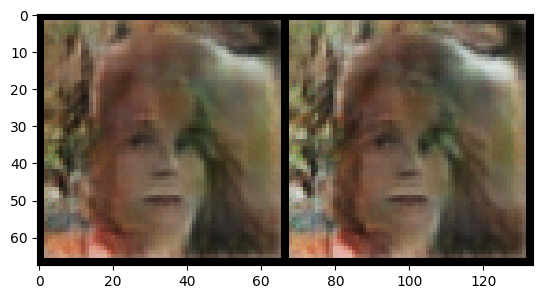

Image LPIPS is 0.08201637119054794


In [17]:
# Now visualizing the images
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item()
print(f"Image LPIPS is {cur_lpips}")


Finally, you need to account for the impact of different values of ϵ, so that the perceptual path length converges as ϵ→∞. In order to do this, PPL divides by ϵ2.

In [20]:
ppl = cur_lpips / (eps ** 2)
print(f"Our final sample PPL is {ppl}")

Our final sample PPL is 2.050409279763698


In [21]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    """
    Perceptual path length function: Combines the above steps into one PPL function
    """
    # Sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_w: {ppl_w(gen, nn.Identity()).item()}")

PPL_w: 17.68737030029297


#### Spherical Interpolation

Because you sample points in z from a Gaussian, we use spherical interpolation instead of linear interpolation to interpolate in z-space. We can use scipy.spatial.geometric_slerp for this.

In [22]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1 - t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

def ppl_z(gen, num_samples=10, eps=1e-4):
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_z: {ppl_z(gen).item()}")

PPL_z: 17.276182174682617
